### Data Analysis of evSeq minION results 


In [2]:
# Import
import sys
sys.path.append("/home/emre/github_repo/MinION")
from minION.util import IO_processor
from minION import analyser
from minION import consensus

import importlib
importlib.reload(analyser)
importlib.reload(consensus)
importlib.reload(IO_processor)
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import numpy as np
from Bio import SeqIO
import matplotlib.pyplot as plt
import gzip

In [33]:
# Functions 

# Pandas releated

def rewrite_Plate_name(entry):
    entry = entry[-1]

    return int(entry)

def rewrite_Well_name(entry):
    num = int(entry[1:])
    new_entry = entry[0] + str(num)

    return new_entry

def single_plate_annotation(entry):
    row = ["A", "B", "C", "D", "E", "F", "G", "H"]
    new_well_name = row[int(entry["Plate"]) - 1] + entry["Well"][1:]
    entry["Well"] = new_well_name
    return entry

def variant_combo(entry):
    if entry in ["#PARENT#", "NC"]:
        return entry
    elif entry == float("nan"):
        return entry
    else:
        new_entry = "_".join(entry)       
        return new_entry

def transform(entry):
    # If the entry is either DEAD or PARENT, return empty lists
    if entry in ["#DEAD#", "#PARENT#"]:
        return [], [], []
    else:
        # Split the entry based on the underscore
        mutations = entry.split("_")
        parent_combo = []
        positions = []
        new_aa = []
        for mutation in mutations:
            # Append the first character to parent_combo, the middle to positions, and the last to new_aa

            #Skip if parent is equal to new_aa
            if mutation[0] == mutation[-1]:
                continue

            elif mutation.find("DEL") != -1:
                parent_combo.append(mutation[0])
                positions.append(mutation[1:-3])
                new_aa.append("DEL")
            
            else:
                parent_combo.append(mutation[0])
                positions.append(mutation[1:-1])
                new_aa.append(mutation[-1])

        return parent_combo, positions, new_aa

def transform_ref(entry):

    parent_combo = []
    positions = []
    new_aa = []

    try:

        for variant in entry:

            if variant in ["#DEAD#", "#PARENT#"]:
                return ["-"], ["-"], ["-"]

            elif variant.find("DEL") != -1:
                parent_combo.append(variant[0])
                positions.append(variant[1:-3])
                new_aa.append("DEL")
            
            else:
                parent_combo.append(variant[0])
                positions.append(variant[1:-1])
                new_aa.append(variant[-1])
        return parent_combo, positions, new_aa
    
    except:
        return ["NA"], ["NA"], ["NA"]
        
def substract_by_index(positions, index):
    new_positions = []
    for pos in positions:
        new_positions.append(str(int(pos) - index))
    
    return new_positions

# Split Variant Combo
def split_variant_combo(entry):
    if entry in ["#DEAD#", "#PARENT#"]:
        return [entry]
    else:
        return entry.split("_")
    
def combine_variant_combo(entry):
    if entry in ["#DEAD#", "#PARENT#"]:
        return entry
    else:
        return "_".join(entry)

def compare_mutations(row, mutation_only = True):

    if isinstance(row['Variant_x'], float):
        return pd.Series([0, 0, [], []], index=['Correct', 'Missed', 'CorrectMutations', 'MissedMutations'])

    if mutation_only and row['Variant_Combo_Ref'] in [["#DEAD#"], ["#PARENT#"]]:
        return pd.Series([0, 0, [], []], index=['Correct', 'Missed', 'CorrectMutations', 'MissedMutations'])

    
    mutations1 = set(row['Variant_Combo_Ref'])
    mutations2 = set(row['Variant_x'])
    
    correct_mutations = mutations1.intersection(mutations2)
    missed_mutations = mutations1.difference(mutations2)
    
    return pd.Series([len(correct_mutations), len(missed_mutations), list(correct_mutations), list(missed_mutations)], index=['Correct', 'Missed', 'CorrectMutations', 'MissedMutations'])

def compare_only_Parent(row):

    if isinstance(row['Variant_x'], float):
        return pd.Series([0, 0, [], []], index=['Correct', 'Missed', 'CorrectMutations', 'MissedMutations'])
    
    if row['Variant_Combo_Ref'] in [["#PARENT#"]]:
        mutations1 = set(row['Variant_Combo_Ref'])
        mutations2 = set(row['Variant_x'])
        
        correct_mutations = mutations1.intersection(mutations2)
        missed_mutations = mutations1.difference(mutations2)
        return pd.Series([len(correct_mutations), len(missed_mutations), list(correct_mutations), list(missed_mutations)], index=['Correct', 'Missed', 'CorrectMutations', 'MissedMutations'])

    else:
         return pd.Series([0, 0, [], []], index=['Correct', 'Missed', 'CorrectMutations', 'MissedMutations'])

def num_mutations(row):
    if isinstance(row['Variant_x'], float):
        return 0
    
    if row['Variant_Combo_Ref'] in [["#DEAD#"], ["#PARENT#"]]:
        return 0
    
    else:
        return len(row['Variant_Combo_Ref'])
    
def count_parent(row):
    if isinstance(row['Variant_x'], float):
        return 0
    
    if row['Variant_Combo_Ref'] in [["#PARENT#"]]:
        return 1
    
    else:
        return 0

def count_all(row):

    if isinstance(row['Variant_Combo_Ref'], float):
        return 0
    
    elif row['Variant_Combo_ref'] in [["#PARENT#"]]:
        return 1
    
    else:
        return len(row['Variant_Combo_Ref'])


# Function to create VariantCombo
def create_variant_combo(row):
    variant_combos = []
    for parent, pos, aa in zip(row['ParentCombo'], row['Positions'], row['NewAA']):
        if parent and pos and aa:
            variant_combos.append(f"{parent}{pos}{aa}")
    return variant_combos if variant_combos else ["#PARENT#"] if not row['ParentCombo'] else ["#DEAD#"]
        

In [ ]:
# Import Data

#ref_df = pd.read_csv('/home/emre/minION_results/JLK-I-027/07252022 - Jenni Kennemur/evSeqOutput/20220725-174936/OutputCounts/Bases_Coupled_Max.csv')



#ref_df["Plate"] = ref_df["Plate"].apply(lambda x: rewrite_Plate_name(x))
#ref_df["Well"] = ref_df["Well"].apply(lambda x: rewrite_Well_name(x))

In [ ]:
ref_df = ref_df[ref_df["AlignmentFrequency"] > 0.7]

In [ ]:
#demultiplexer_path =  "/home/emre/minION_results/MinION_RBC_0902723_sup/Demultiplex_cpp_70_short"
#demultiplexer_path = "/home/emre/minION_results/Flongle_3RBC_sup/Demultiplex_cpp_70"

#template_fasta = Path("/home/emre/github_repo/MinION/minION/refseq/hetcpiii.fasta")
barcodes = IO_processor.get_barcode_dict(Path(demultiplexer_path))
variant_df = analyser.get_variant_df_nn(demultiplexer_path,template_fasta, barcodes, consensus_folder_name="consensus" ,sequences=True, merge=True)
variant_template_df = analyser.template_df(barcodes, rowwise=False)

### TAM-LQv 

- Single Plate with 12 Front Barcodes and 8 Reverse Barcodes
- H8 is negative control
- Min Read Length = 15

In [ ]:
demultiplexer_path = "/home/emre/minION_results/TamLQV96_sup/Demultiplex_cpp_70/"
template_fasta = Path("/home/emre/tam-lqv.fasta")
barcode_dicts = IO_processor.get_barcode_dict(Path(demultiplexer_path))

In [ ]:
# Barcode distribution
summary = analyser.read_summary_file(demultiplexer_path)
# Raw reads = 44'875

N_reads = summary.groupby(["RBC","FBC"])["FBC"].value_counts().reset_index()

rbc_unclassified = summary[summary["RBC"] == "unclassified"].shape[0]
fbc_unclassified = summary[summary["FBC"] == "unclassified"].shape[0]
classified = summary[(summary["RBC"] != "unclassified") & (summary["FBC"] != "unclassified")].shape[0]

demultiplexed = {"Group" : ["Classified", "RBC Unclassified", "FBC Unclassified"], "Value" : [classified, rbc_unclassified, fbc_unclassified]}
demultiplexed = pd.DataFrame(demultiplexed)

In [ ]:
# Plotting
df = demultiplexed.copy()
fig, ax = plt.subplots()
bars = ax.bar(df['Group'], df['Value'], color = ["lightgrey"] ,edgecolor='black', linewidth=1, width=0.4)
ax.tick_params(size=14, labelsize=14)

# Optional: You can also add the values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', size=10)

# Setting the labels
ax.set_ylabel('# of Reads')

# Display the plot
plt.savefig("figures/tam_classified.png", dpi = 300, bbox_inches='tight')
plt.show()

In [ ]:
threshold = 70

fig, ax = plt.subplots(figsize=(12, 7))

bin_size = 2  
bins = np.arange(0, summary['RBC_Score'].max() + bin_size, bin_size)
sns.set_style("whitegrid")

sns.histplot(data=summary[summary['RBC_Score'] >= threshold], x="RBC_Score", bins=bins, color='lightgreen', edgecolor = "black" , ax=ax)

sns.histplot(data=summary[summary['RBC_Score'] < threshold], x="RBC_Score", bins=bins, color='lightcoral',  edgecolor = "black" , ax=ax)

plt.axvline(x=threshold, color='r', linestyle='--')
plt.tick_params(size=12, labelsize=12)
plt.xlabel("RBC Score", size=16)
plt.ylabel("# of Reads", size=16)
plt.savefig("figures/tam_rbc_score.png", dpi = 300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(12, 7))

df_tmp = summary[(summary["RBC_Score"] >= threshold)]

bin_size = 2  
bins = np.arange(0, df_tmp['FBC_Score'].max() + bin_size, bin_size)
sns.set_style("whitegrid")
sns.histplot(data=df_tmp[df_tmp['FBC_Score'] >= threshold], x="FBC_Score", bins=bins, color='lightgreen', edgecolor = "black" , ax=ax)

sns.histplot(data=df_tmp[df_tmp['FBC_Score'] < threshold], x="FBC_Score", bins=bins, color='lightcoral',  edgecolor = "black" , ax=ax)

plt.axvline(x=threshold, color='r', linestyle='--')
plt.tick_params(size=12, labelsize=12)
plt.xlabel("FBC Score", size=16)
plt.ylabel("# of Reads", size=16)
plt.savefig("figures/tam_fbc_score.png", dpi = 300, bbox_inches='tight')
plt.show()

In [ ]:
rbc_counts

In [ ]:
# RBC counts

rbc_counts = summary.groupby(["RBC"])["RBC"].value_counts().reset_index()
rbc_counts = rbc_counts[rbc_counts["RBC"] != "unclassified"].sort_values(by = "RBC", ascending = True)

# FBC counts
fbc_counts = summary.groupby(["FBC"])["FBC"].value_counts().reset_index()
fbc_counts = fbc_counts[fbc_counts["FBC"] != "unclassified"].sort_values(by = "FBC", ascending = True)


# Barplot
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(rbc_counts["RBC"], rbc_counts["count"], color = "lightgrey", edgecolor = "black")
plt.tick_params(size=12, labelsize=12)

for i, v in enumerate(rbc_counts["count"]):
    ax.text(i - 0.2, v + 100, str(v), color='black', size = 12)

plt.xlabel("Reverse Barcodes (RBC)", size=16)
plt.ylabel("# of Reads", size=16)

plt.savefig("figures/tam_rbc_counts.png", dpi = 300, bbox_inches='tight')


fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(fbc_counts["FBC"], fbc_counts["count"], color = "lightgrey", edgecolor = "black")
plt.tick_params(size=12, labelsize=12)

for i, v in enumerate(fbc_counts["count"]):
    ax.text(i - 0.2, v + 100, str(v), color='black', size = 12)

plt.xlabel("Forward Barcodes (FBC)", size=16)
plt.ylabel("# of Reads", size=16)

plt.savefig("figures/tam_fbc_counts.png", dpi = 300, bbox_inches='tight')



In [ ]:
# Get columns which eiter have unclassified in RBC or FBC
N_reads[(N_reads["RBC"] == "unclassified") | (N_reads["FBC"] == "unclassified")]

In [ ]:
# Get the Variant df with detected mutations
variant_df = analyser.get_variant_df_custom(demultiplexer_path, template_fasta, barcode_dicts, consensus_folder_name = "consensus", merge = True)
variant_df.dropna(subset=["count"], inplace=True)
ref_df = pd.read_csv("/home/emre/tam_lqv.csv")


variant_df = variant_df.apply(single_plate_annotation, axis=1)



variant_df["Variant_Combo"] = variant_df["Variant"].apply(lambda x: variant_combo(x))


In [ ]:
# Sort by count 
variant_df.sort_values(by = "count", ascending = True, inplace = True)
variant_df

In [ ]:
variant_df = variant_df.merge(ref_df, on=[ "Well"], how="inner")


variants_list_ref = []

for variant in variant_df["Variant_Combo_Ref"]:
    if variant in ["#DEAD#", "#PARENT#"]:
        variants_list_ref.append(variant)
    else:
        for var in variant:
            variants_list_ref.append(var)

variants_list_minION = []

for variant in variant_df["Variant_x"]:
    if variant in ["#DEAD#", "#PARENT#"]:
        variants_list_minION.append(variant)
    else:
        for var in variant:
            variants_list_minION.append(var)


variant_df["Variant_Combo_Ref"] = variant_df["Variant_Combo"].apply(lambda x: split_variant_combo(x))

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7))
ax.bar(mut, )


# Flongle & MinION using guppy barcoder

- MinION_RBC / Demultiplex 45 -> Guppy barcoder with min Score of 45 minION



## 1. Experiment - Flongle Cell 09/05/2023 
 - Jay's error prone PCR library
 - Flongle Cell
 - Barcodes without mask 

In [ ]:
# Flongle basecalled data
fastq_files_path = "/home/emre/minION_results/20230905_errorprone-3_test_sup/basecalled/*"
fastq_files = glob.glob(fastq_files_path)

# Get Statistics for length distribution and quality scores
lengths = []
qualities = []

for fastq_file in fastq_files:
    with gzip.open(fastq_file, "rt") as handle:
        for record in SeqIO.parse(handle, "fastq"):
            # if len(record.seq) > 3438.0 or len(record.seq) < 520.0:
            if len(record.seq) > 1000 or len(record.seq) < 750:
                continue
            else:
                lengths.append(len(record.seq))
                qualities.append(np.mean(record.letter_annotations["phred_quality"]))

# Number of reads
n_reads = len(lengths)


mean_length, median_length, max_length, min_length = np.mean(lengths), np.median(lengths), np.max(lengths), np.min(lengths)

# Coefficient of variation
cv = np.std(lengths) / np.mean(lengths)

# Outlier detection
outlier_max_threshold = 0.95
upper_outlier_length = np.quantile(lengths, outlier_max_threshold)
lower_outlier_length = np.quantile(lengths, 1 - outlier_max_threshold)

print(upper_outlier_length, lower_outlier_length)


In [ ]:
# Histogram of length and the mean quality score at each 
df = pd.DataFrame({"Read Length" : lengths, "Phred Quality Score" : qualities})
df.describe()

In [ ]:
# Group by 'Read Length' and calculate the mean 'Phred Quality Score' for each group
grouped = df.groupby('Read Length')['Phred Quality Score'].mean()

# Define the number of bins for the histogram
num_bins = 50
bin_ranges = pd.cut(df['Read Length'], bins=num_bins)
grouped = df.groupby(bin_ranges)['Phred Quality Score']

# Calculate mean and standard deviation for each bin
mean_qualities = grouped.mean()
std_qualities = grouped.std()
#cv_qualities = grouped.std() / grouped.mean()
bin_centers = mean_qualities.index.map(lambda x: x.mid)

# Creating the figure and the first axes for the histogram
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting the histogram
color_hist = 'tab:blue'
ax1.set_xlabel('Read Length', size=16)
ax1.set_ylabel('Count', color="black", size=16)
ax1.hist(df['Read Length'], bins=num_bins, alpha=0.8, color="lightgrey", edgecolor = "black")
ax1.tick_params(axis='y', labelcolor="black")

# Creating the second axes for the mean quality score
ax2 = ax1.twinx()

# Adding standard deviation with fill_between
ax2.fill_between(bin_centers, 
                 mean_qualities - std_qualities, 
                 mean_qualities + std_qualities, 
                 color='palevioletred', alpha=0.3)

ax2.scatter(bin_centers, mean_qualities, color="palevioletred", s=50, zorder=3)
ax2.plot(bin_centers, mean_qualities, color="palevioletred", zorder=3)

color_line = 'tab:red'
ax2.set_ylabel('Mean Phred Quality Score', color="palevioletred", size=16)
ax2.tick_params(axis='y', labelcolor="palevioletred")

# Title and layout adjustment
#plt.title('Read Length Distribution with Mean and Std Dev of Phred Quality Scores')
fig.tight_layout()
plt.savefig("figures/flongle_read_length_quality_plot.png", dpi = 300, bbox_inches='tight')
plt.show()

In [ ]:
df = pd.DataFrame({"Read Length" : lengths, "Phred Quality Score" : qualities})
#df.describe().round(2).to_csv("data/JLK_flongle_stats.csv")

In [ ]:
# Bin the quality scores
bin_size = 5
num_bins = 200  # for 600 bp reads

# Dictionary to hold the binned data
binned_qualities = {i: {'mean': [], 'std': []} for i in range(num_bins)}

# Process each read
for read_id, qualities in read_qualities.items():
    # Bin the quality scores
    for i in range(num_bins):
        start_idx = i * bin_size
        end_idx = start_idx + bin_size
        bin_qualities = qualities[start_idx:end_idx]

        # Check if the bin is not empty
        if bin_qualities:
            # Calculate mean and standard deviation
            mean_quality = np.mean(bin_qualities)
            std_quality = np.std(bin_qualities)

            # Append to the binned_qualities dictionary
            binned_qualities[i]['mean'].append(mean_quality)
            binned_qualities[i]['std'].append(std_quality)

In [ ]:
# Rewrite variant_df for guppy basecaller

d_path = "/home/emre/minION_results/MinION_RBC_0902723_sup/demultiplex_45"

barcode_dicts = IO_processor.get_barcode_dict(Path(d_path))

variant_template_df = analyser.template_df(barcode_dicts)

variants = {"RBC": [], "FBC": [], "Position": [], "Variant": [], "Quality-Score": []}

variants["Sequence"] = []

template = analyser.get_template_sequence(template_fasta) # Reference sequence

n_counts = pd.DataFrame()
for barcode_id, barcode_dict in barcode_dicts.items():
    n_counts_rbc = analyser.read_summary_file(barcode_id)["barcode_arrangement"].value_counts().reset_index()
    rbc_basename = os.path.basename(barcode_id)
    n_counts_rbc = n_counts_rbc[n_counts_rbc["barcode_arrangement"] != "unclassified"]
    n_counts_rbc.rename(columns={"barcode_arrangement" : "FBC", "count" : "n_counts"}, inplace=True)
    n_counts_rbc["RBC"] = rbc_basename
    n_counts = pd.concat([n_counts, n_counts_rbc], axis=0)
    
for barcode_id, barcode_dict in barcode_dicts.items():

    rbc = os.path.basename(barcode_id)

    for front_barcode in barcode_dict:

        fbc = os.path.basename(front_barcode)

        front_barcode = os.path.join(front_barcode)

        fasta_file = os.path.join(front_barcode, "consensus" ,"consensus.fastq")

        # Check if consensus file exists
        if not os.path.exists(fasta_file):
            print(f"Consensus file in {front_barcode} does not exist, skipping {fbc}")
            continue

        try:
            consensus = analyser.get_consensus_sequence(fasta_file, True)
        
        except:
            print(f"Skipping {rbc}/{fbc}")
            print(consensus)
            continue

        
        variants["Sequence"].append(consensus["Sequence"][0])

        nn_variants = analyser.call_variant_nn(template, consensus["Sequence"][0], consensus["Quality-Score"][0])



        variants["RBC"].append(rbc)
        variants["FBC"].append(fbc)
        variants["Position"].append(nn_variants["Position"])
        variants["Variant"].append(nn_variants["Variant"])
        variants["Quality-Score"].append(nn_variants["Quality-Score"])



### Flongle Cell of MinION_RBC_09

In [ ]:

variant_df =variant_df.merge(variant_template_df, on=["Plate", "Well"], how="right")


In [ ]:
ref_df[['ParentCombo', 'Positions', 'NewAA']] = ref_df['Variant'].apply(lambda x: pd.Series(transform(x)))

#ref_df['Positions'] = ref_df['Positions'].apply(lambda x: substract_by_index(x, 2722))
variant_df[['ParentCombo', 'Positions', 'NewAA']] = variant_df['Variant'].apply(lambda x: pd.Series(transform_ref(x)))



In [ ]:
#variant_df = variant_df.merge(ref_df[["Plate","Well"]], on=["Plate", "Well"], how="inner")


In [ ]:


#ref_df["VariantCombo_splitted"] = ref_df["VariantCombo"].apply(lambda x: split_variant_combo(x))
# ref_df["Variant_splitted"] = ref_df["Variant"].apply(lambda x: combine_variant_combo(x))
variant_df["Variant_Combo_Ref"] = variant_df["Variant_Combo"].apply(lambda x: split_variant_combo(x))

In [ ]:
# variants_list_ref = []

# for variant in ref_df["VariantCombo_splitted"]:
#     if variant in ["#DEAD#", "#PARENT#"]:
#         variants_list_ref.append(variant)
#     else:
#         for var in variant:
#             variants_list_ref.append(var)

# variants_list_evSeq = []
# evSeq_df_tmp = variant_df.dropna()
# for variant in evSeq_df_tmp["Variant"]:
#     if variant in ["#DEAD#", "#PARENT#"]:
#         variants_list_evSeq.append(variant)

#     elif variant == float("nan"):
#         continue
#     else:
#         for var in variant:
#             variants_list_evSeq.append(var)

In [ ]:
variant_df = variant_df[~variant_df["Well"].isin(["A1", "A12", "H1", "H12"])]
ref_df = ref_df[~ref_df["Well"].isin(["A1", "A12", "H1", "H12"])]

In [ ]:
# Num mutations

mut = {"Reference" : [], "minION" : []}

# Get unique entries
unique_entries_ref = list(set(variants_list_ref))
unique_entries_minION = list(set(variants_list_minION))

mut["Reference"].append(len(unique_entries_ref))
mut["minION"].append(len(unique_entries_minION))
mut = pd.DataFrame(mut)

In [ ]:
# Seaborne plot
sns.set_theme(style="whitegrid")
ax = sns.barplot(x=mut.columns, y=mut.iloc[0])
ax.set_title("Number of unique mutations")
ax.set_ylabel("Number of mutations")
#ax.set_xlabel("Reference vs minION-guppy")
ax.text(0, mut.iloc[0,0] + 0.5, mut.iloc[0,0], ha='center', va='bottom', color='black')
ax.text(1, mut.iloc[0,1] + 0.5, mut.iloc[0,1], ha='center', va='bottom', color='black')

# Save plot
plt.savefig("/home/emre/github_repo/MinION/examples/TamLQV_mutations.png")
plt.show()

In [ ]:

ref_df['VariantCombo'] = ref_df.apply(create_variant_combo, axis=1)



In [ ]:
ref_df = ref_df[['Plate', 'Well', 'VariantCombo']]

In [ ]:
ref_df = ref_df.rename(columns={"VariantCombo" : "Variant_Combo_Ref"})

In [ ]:
merged_df = pd.merge(ref_df, variant_df, on=['Plate', "Well"])


In [ ]:
variant_df

In [ ]:
df = variant_df.copy()
df[['Correct', 'Missed', 'CorrectMutations', 'MissedMutations']] = df.apply(compare_mutations,axis=1)
#Remove Well A1, A12, H1, H12
#df = df[~df["Well"].isin(["A1", "A12", "H1", "H12"])]
accuracy = df["Correct"].sum() / df.apply(num_mutations, axis=1).sum()

In [ ]:
def find_max(entry):
    if isinstance(entry, list) and entry:
        if entry[0] == "#PARENT#":
            return "#PARENT#"
        else:
            # Assuming you want to find the max string in the list
            return max(entry)
    return "Invalid Entry"

result = df["Position"].apply(find_max).value_counts()
print(result)

In [ ]:
df[df["Missed"] > 0]

In [ ]:
accuracy

In [ ]:
identified = df["Correct"].sum() / df.apply(num_mutations, axis=1).sum()

In [ ]:
Accuracy = {"Method" : ["Mutation only", "Parent only", "All"], "Accuracy" : [0.970, 0.877, 0.876]}

In [ ]:
# Seaborne plot
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Method", y="Accuracy", data=Accuracy)
#ax.set_title("Mutation Calling accuracy minION")
ax.set_ylabel("Accuracy")
ax.text(0, Accuracy["Accuracy"][0] + 0.01, Accuracy["Accuracy"][0], ha='center', va='bottom', color='black')
ax.text(1, Accuracy["Accuracy"][1] + 0.01, Accuracy["Accuracy"][1], ha='center', va='bottom', color='black')
ax.text(2, Accuracy["Accuracy"][2] + 0.01, Accuracy["Accuracy"][2], ha='center', va='bottom', color='black')

# Save plot
plt.savefig("/home/emre/github_repo/MinION/examples/Flongle_cpp_70_accuracy.png")
plt.show()

### PgA9 (Ravis data) - 20231119_1502_MN41105_FAX99808_f9cbc263

- Error Prone PCR plate

In [18]:
demultiplexer_path = "/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/"
template_fasta = Path("/home/emre/PgA9.fasta")
barcode_dicts = IO_processor.get_barcode_dict(Path(demultiplexer_path))

In [ ]:
# Get Quality scores

# Flongle basecalled data
fastq_files_path = "/var/lib/minknow/data/20231119_RL-8-45_PgA9-2_500uM/no_sample/20231119_1502_MN41105_FAX99808_f9cbc263/fastq_pass/*"
fastq_files = glob.glob(fastq_files_path)

# Get Statistics for length distribution and quality scores
lengths = []
qualities = []

for fastq_file in fastq_files:
    with gzip.open(fastq_file, "rt") as handle:
        for record in SeqIO.parse(handle, "fastq"):
            # if len(record.seq) > 3438.0 or len(record.seq) < 520.0:
            if len(record.seq) > 3438 or len(record.seq) < 520:
                continue
            else:
                lengths.append(len(record.seq))
                qualities.append(np.mean(record.letter_annotations["phred_quality"]))

# Number of reads
n_reads = len(lengths)


mean_length, median_length, max_length, min_length = np.mean(lengths), np.median(lengths), np.max(lengths), np.min(lengths)

# Coefficient of variation
cv = np.std(lengths) / np.mean(lengths)

# Outlier detection
outlier_max_threshold = 0.95
upper_outlier_length = np.quantile(lengths, outlier_max_threshold)
lower_outlier_length = np.quantile(lengths, 1 - outlier_max_threshold)

print(upper_outlier_length, lower_outlier_length)


In [ ]:
# Histogram of length and the mean quality score at each 
df = pd.DataFrame({"Read Length" : lengths, "Phred Quality Score" : qualities})
df.describe()

In [ ]:
# Group by 'Read Length' and calculate the mean 'Phred Quality Score' for each group
grouped = df.groupby('Read Length')['Phred Quality Score'].mean()

# Define the number of bins for the histogram
num_bins = 50
bin_ranges = pd.cut(df['Read Length'], bins=num_bins)
grouped = df.groupby(bin_ranges)['Phred Quality Score']

# Calculate mean and standard deviation for each bin
mean_qualities = grouped.mean()
std_qualities = grouped.std()
#cv_qualities = grouped.std() / grouped.mean()
bin_centers = mean_qualities.index.map(lambda x: x.mid)

# Creating the figure and the first axes for the histogram
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting the histogram
color_hist = 'tab:blue'
ax1.set_xlabel('Read Length', size=16)
ax1.set_ylabel('Count', color="black", size=16)
ax1.hist(df['Read Length'], bins=num_bins, alpha=0.8, color="lightgrey", edgecolor = "black")
ax1.tick_params(axis='y', labelcolor="black")

# Creating the second axes for the mean quality score
ax2 = ax1.twinx()

# Adding standard deviation with fill_between
ax2.fill_between(bin_centers, 
                 mean_qualities - std_qualities, 
                 mean_qualities + std_qualities, 
                 color='palevioletred', alpha=0.3)

ax2.scatter(bin_centers, mean_qualities, color="palevioletred", s=50, zorder=3)
ax2.plot(bin_centers, mean_qualities, color="palevioletred", zorder=3)

color_line = 'tab:red'
ax2.set_ylabel('Mean Phred Quality Score', color="palevioletred", size=16)
ax2.tick_params(axis='y', labelcolor="palevioletred")

# Title and layout adjustment
#plt.title('Read Length Distribution with Mean and Std Dev of Phred Quality Scores')
fig.tight_layout()
plt.savefig("figures/PgA9_score_dist_MN41105_FAX99808.png", dpi = 300, bbox_inches='tight')
plt.show()

In [19]:
# Barcode distribution
summary = analyser.read_summary_file(demultiplexer_path)

N_reads = summary.groupby(["RBC","FBC"])["FBC"].value_counts().reset_index()

rbc_unclassified = summary[summary["RBC"] == "unclassified"].shape[0]
fbc_unclassified = summary[summary["FBC"] == "unclassified"].shape[0]
classified = summary[(summary["RBC"] != "unclassified") & (summary["FBC"] != "unclassified")].shape[0]

demultiplexed = {"Group" : ["Classified", "RBC Unclassified", "FBC Unclassified"], "Value" : [classified, rbc_unclassified, fbc_unclassified]}
demultiplexed = pd.DataFrame(demultiplexed)

In [24]:
294367 / summary.shape[0]
66931 / summary.shape[0]
84161 / summary.shape[0]

0.1889309678331788

In [ ]:
# Plotting
df = demultiplexed.copy()
fig, ax = plt.subplots()
bars = ax.bar(df['Group'], df['Value'], color = ["lightgrey"] ,edgecolor='black', linewidth=1, width=0.4)
ax.tick_params(size=14, labelsize=14)

# Optional: You can also add the values on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), va='bottom', ha='center', size=10)

# Setting the labels
ax.set_ylabel('# of Reads', size=16)

# Display the plot
plt.savefig("figures/PgA9_classified.png", dpi = 300, bbox_inches='tight')
plt.show()

In [ ]:
protein_name = "PgA9"


threshold = 70


fig, ax = plt.subplots(figsize=(12, 7))

bin_size = 2  
bins = np.arange(0, summary['RBC_Score'].max() + bin_size, bin_size)
sns.set_style("whitegrid")

sns.histplot(data=summary[summary['RBC_Score'] >= threshold], x="RBC_Score", bins=bins, color='lightgreen', edgecolor = "black" , ax=ax)

sns.histplot(data=summary[summary['RBC_Score'] < threshold], x="RBC_Score", bins=bins, color='lightcoral',  edgecolor = "black" , ax=ax)

plt.axvline(x=threshold, color='r', linestyle='--')
plt.tick_params(size=12, labelsize=12)
plt.xlabel("RBC Score", size=16)
plt.ylabel("# of Reads", size=16)
plt.savefig(f"figures/{protein_name}_rbc_score.png", dpi = 300, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(12, 7))

df_tmp = summary[(summary["RBC_Score"] >= threshold)]

bin_size = 2  
bins = np.arange(0, df_tmp['FBC_Score'].max() + bin_size, bin_size)
sns.set_style("whitegrid")
sns.histplot(data=df_tmp[df_tmp['FBC_Score'] >= threshold], x="FBC_Score", bins=bins, color='lightgreen', edgecolor = "black" , ax=ax)

sns.histplot(data=df_tmp[df_tmp['FBC_Score'] < threshold], x="FBC_Score", bins=bins, color='lightcoral',  edgecolor = "black" , ax=ax)

plt.axvline(x=threshold, color='r', linestyle='--')
plt.tick_params(size=12, labelsize=12)
plt.xlabel("FBC Score", size=16)
plt.ylabel("# of Reads", size=16)
plt.savefig(f"figures/{protein_name}_fbc_score.png", dpi = 300, bbox_inches='tight')
plt.show()

In [ ]:
arrangement = summary.groupby(["FBC", "RBC"])["FBC"].value_counts().reset_index()
arrangement = arrangement[(arrangement["FBC"] != "unclassified")]
arrangement = arrangement[(arrangement["RBC"] != "unclassified")]


### Get Variant Sequence

- mini align for PgA5
- Call variant with our custom function

In [16]:
for rbc in barcode_dicts.keys():
    for fbc in barcode_dicts[rbc]:
        print(fbc)
        #consensus.mini_align(fbc, template_fasta , n_threads = 1, prefix = "" , output_name = "alignment")
        break

/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB03/NB87
/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB04/NB87
/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB01/NB87
/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB02/NB87


In [57]:
fbc = Path("/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB02/NB73")
consensus.mini_align(fbc, template_fasta , n_threads = 1, prefix = "" , output_name = "alignment")

Using the existing fai index file /home/emre/PgA9.fasta.fai
Using the existing mmi index file /home/emre/PgA9.fasta.map-ont.mmi
[M::main::0.001*1.49] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.001*1.47] mid_occ = 10
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.001*1.45] distinct minimizers: 111 (100.00% are singletons); average occurrences: 1.000; average spacing: 5.514; total length: 612
[M::worker_pipeline::0.115*1.00] mapped 834 sequences
[M::main] Version: 2.26-r1175
[M::main] CMD: minimap2 -x map-ont --secondary=no -L --MD -t 1 -a /home/emre/PgA9.fasta.map-ont.mmi /home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB02/NB73/trimmed.fastq
[M::main] Real time: 0.115 sec; CPU: 0.115 sec; Peak RSS: 0.006 GB


CompletedProcess(args='mini_align -r /home/emre/PgA9.fasta -i /home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB02/NB73/*.fastq -t 1 -m -p alignment && mv *.bam *.bam.bai /home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB02/NB73/consensus', returncode=0)

In [4]:
variant_df = analyser.get_variant_df_custom(demultiplexer_path, template_fasta, barcode_dicts, consensus_folder_name = "consensus", merge = True)

/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB03/NB87/consensus/alignment.bam
/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB03/NB03/consensus/alignment.bam
/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB03/NB20/consensus/alignment.bam
/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB03/NB48/consensus/alignment.bam
/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB03/NB70/consensus/alignment.bam
/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB03/NB04/consensus/alignment.bam
/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB03/NB88/consensus/alignment.bam
/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB03/NB14/consensus/alignment.bam
/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB03/NB82/consensus/alignment.bam
/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB03/NB54/consensus/alig

In [6]:
variant_df.to_csv("data/PgA9_variant_df.csv")

In [35]:
df = variant_df[variant_df["Plate"] == 3]

In [37]:
df.tail(10)

,Plate,Well,Position,Variant,Quality-Score,count
278,3,H3,[-],[#PARENT#],[-],699.0
279,3,H4,[234],[A234G],[31],18.0
280,3,H5,"[143, 309]","[T143C, C309T]","[34, 36]",855.0
281,3,H6,[-],[#PARENT#],[-],157.0
282,3,H7,[-],[#PARENT#],[-],139.0
283,3,H8,"[195, 359, 556]","[A195C, A359T, T556C]","[34, 37, 35]",853.0
284,3,H9,[56],[T56C],[33],295.0
285,3,H10,[-],[#PARENT#],[-],1743.0
286,3,H11,[245],[T245C],[30],1147.0
287,3,H12,[NA],[NA],[NA],13.0


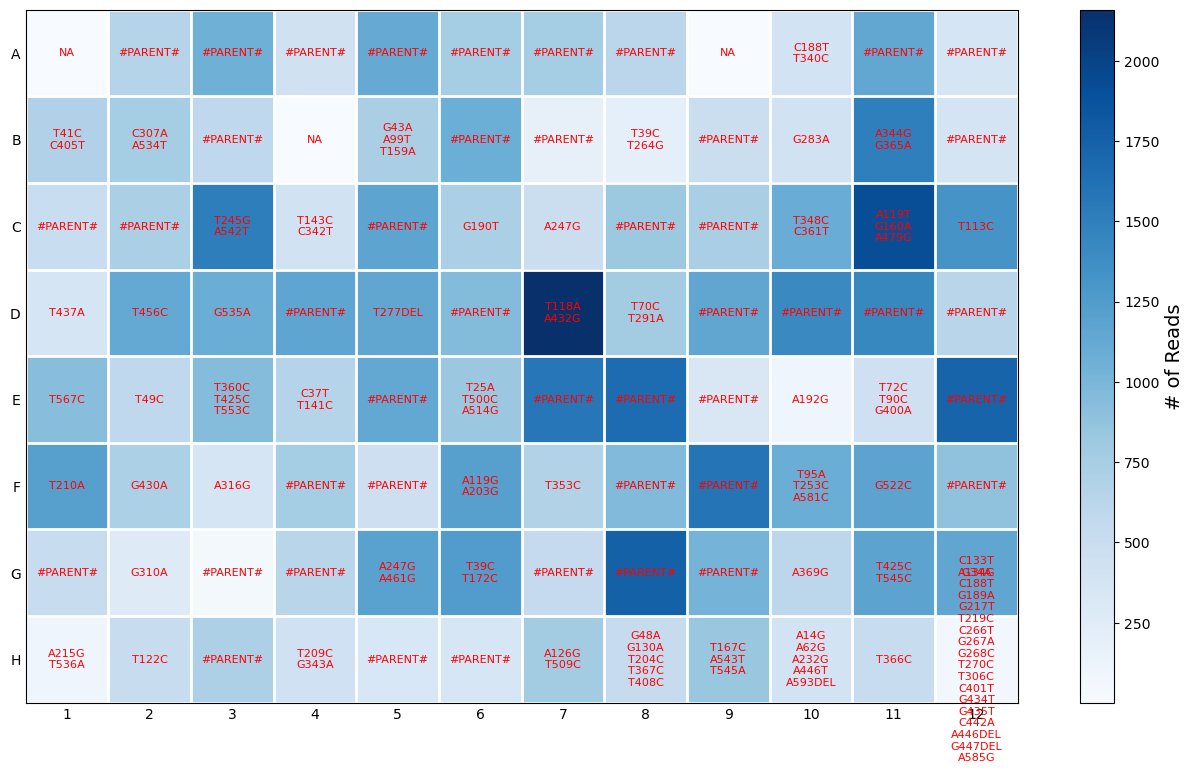

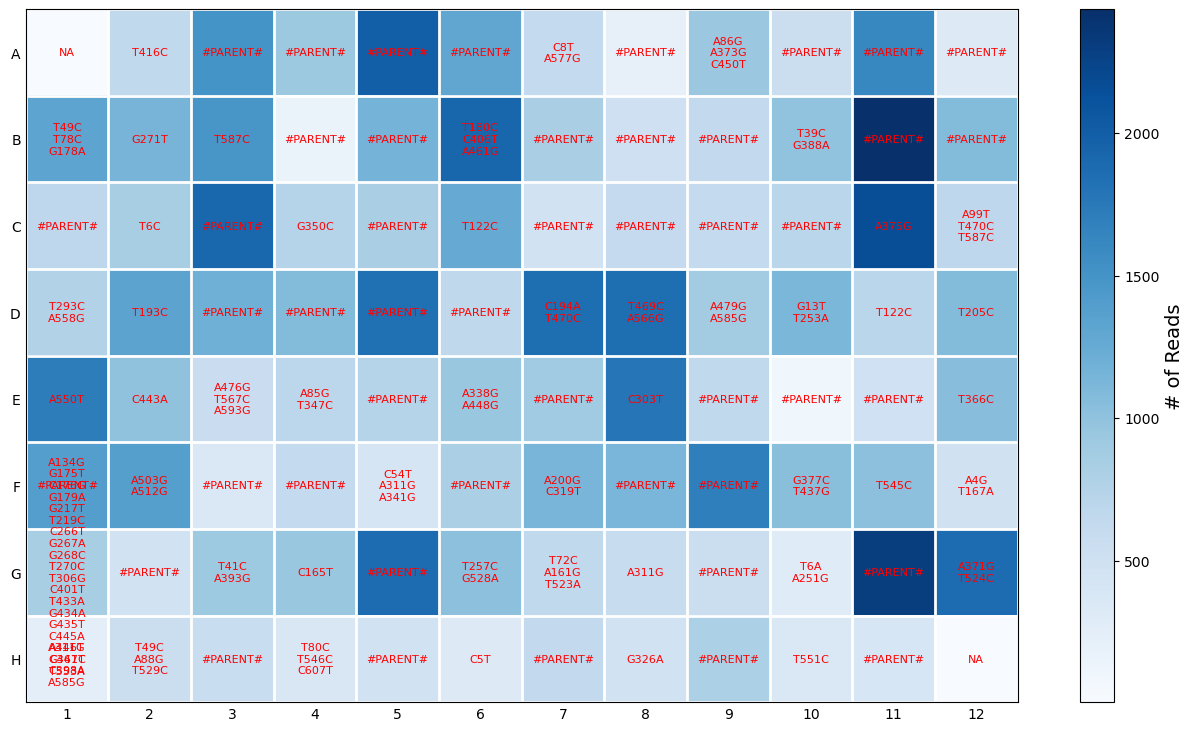

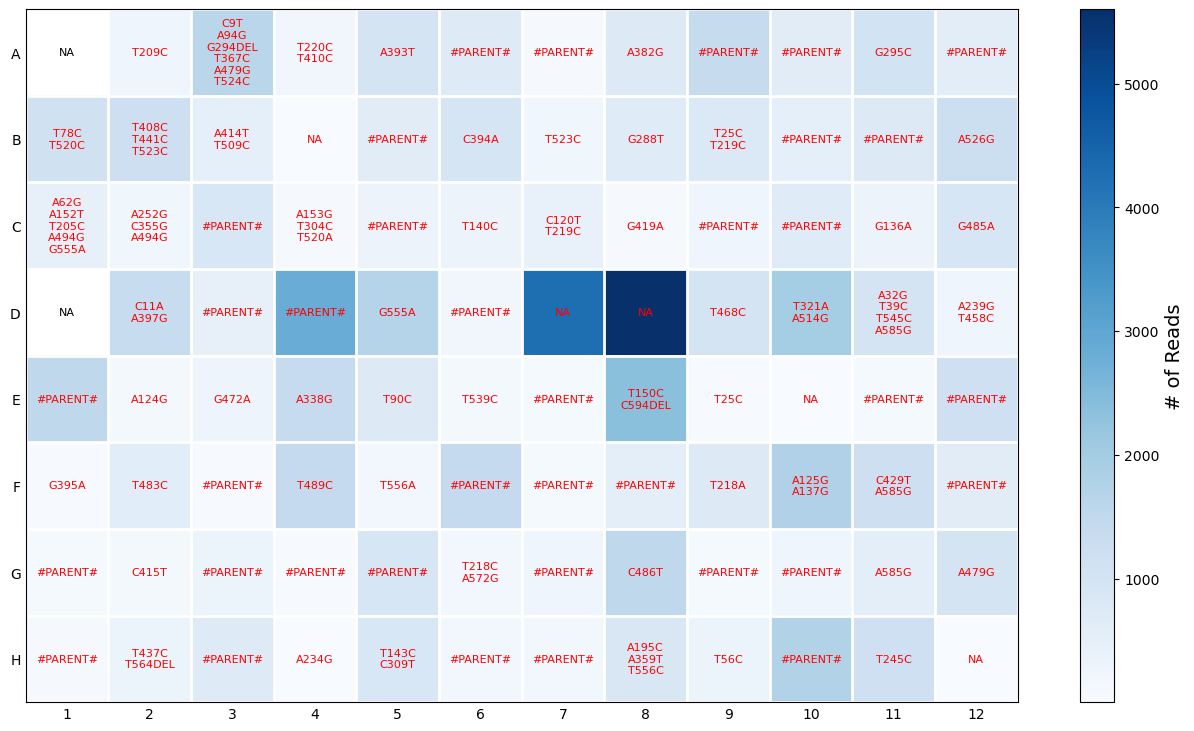

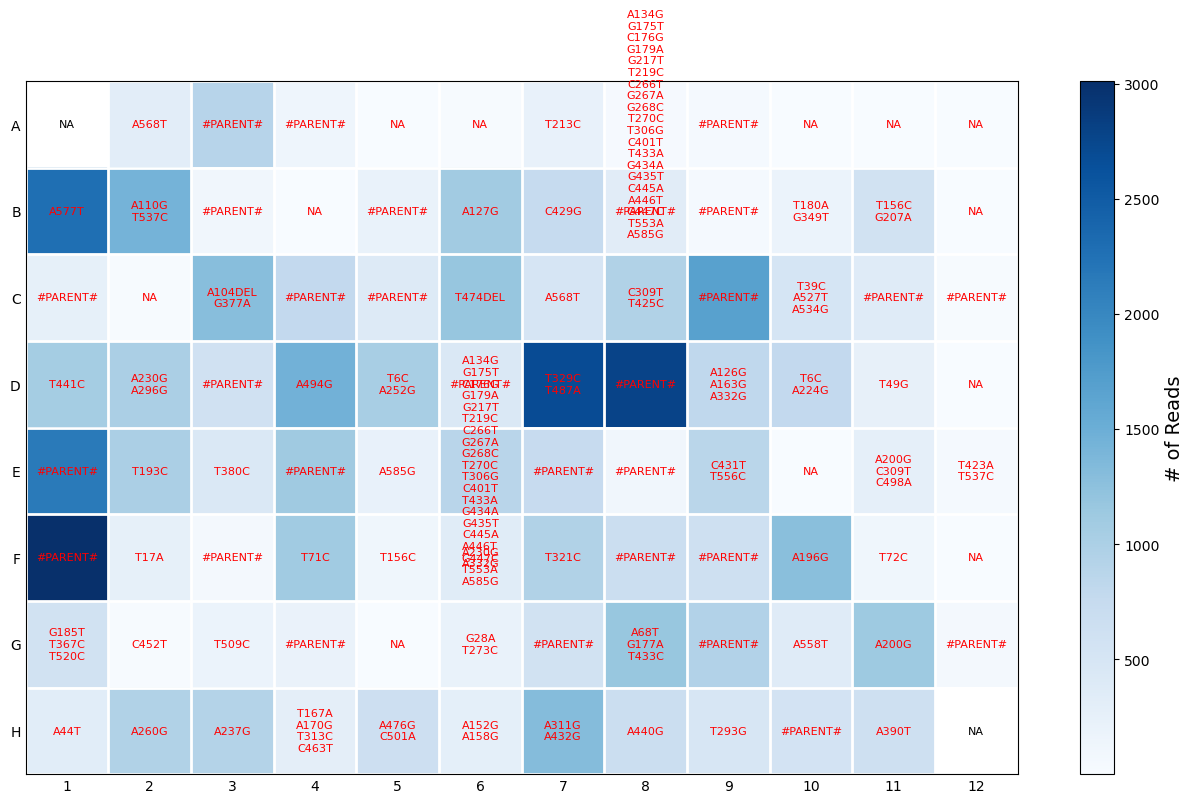

In [13]:
for plate in [1,2,3,4]:
    df = variant_df[variant_df["Plate"] == plate]
    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(16, 9))

    # Initialize the data matrix with NaN for the heatmap
    heatmap_data = np.full((8, 12), np.nan)

    # Fill in the data matrix with 'Reads' values
    for _, row in df.iterrows():
        well_row = 'ABCDEFGH'.index(row['Well'][0])
        well_col = int(row['Well'][1:]) - 1
        heatmap_data[well_row, well_col] = row['count']

    # Labels
    col_labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']
    row_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

    # Heatmap
    im = ax.imshow(heatmap_data, cmap="Blues", aspect='auto')

    # Colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("# of Reads", rotation=90, va="top", size=14)

    # White grid
    ax.set_xticks(np.arange(-.5, 12, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 8, 1), minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=2)
    ax.tick_params(which="minor", size=0)

    # Annotations with variants
    for (i, j), val in np.ndenumerate(heatmap_data):
        if not np.isnan(val):  # Only annotate non-NaN values
            variant_text = '\n'.join(df.loc[df['Well'] == f'{row_labels[i]}{j+1:01d}', 'Variant'].values[0])
            ax.text(j, i, variant_text, ha='center', va='center', color='red', fontsize=8)
        elif np.isnan(val):
            ax.text(j, i, "NA", ha='center', va='center', color='black', fontsize=8)



    # Set the ticks
    ax.set_xticks(np.arange(len(col_labels)))
    ax.set_yticks(np.arange(len(row_labels)))
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Turn off the tick labels if not needed
    ax.tick_params(axis=u'both', which=u'both',length=0)

    plt.savefig(f"figures/heatmap_PgA9_plate_{plate}.png", dpi=300, bbox_inches='tight')

    plt.show()


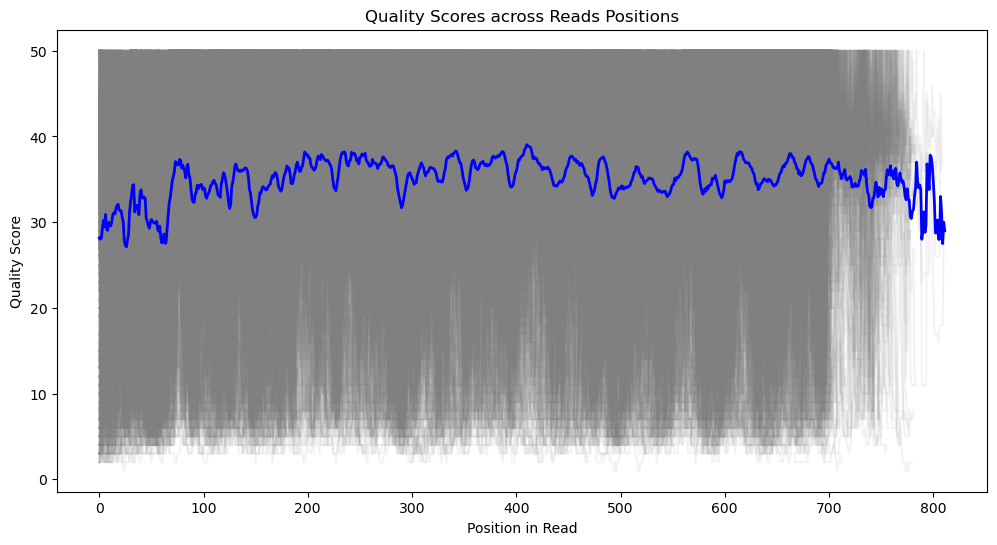

In [52]:
# Initialize a list to store quality scores
quality_scores = []
max_length = 0

fastq_file = "/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB02/NB73/trimmed.fastq"

# Read the FASTQ file
for record in SeqIO.parse(fastq_file, "fastq"):
    scores = record.letter_annotations["phred_quality"]
    quality_scores.append(scores)
    max_length = max(max_length, len(scores))

# Initialize arrays to store total scores and counts
total_scores = np.zeros(max_length)
counts = np.zeros(max_length)

# Accumulate scores and counts
for scores in quality_scores:
    length = len(scores)
    total_scores[:length] += scores
    counts[:length] += 1

# Calculate mean quality scores
mean_scores = total_scores / counts

# Plotting
plt.figure(figsize=(12, 6))
for scores in quality_scores:
    plt.plot(scores, color='grey', alpha=0.1)  # Plot each read's quality score in transparent grey
plt.plot(mean_scores, color='blue', linewidth=2)  # Plot the mean quality score

plt.title("Quality Scores across Reads Positions")
plt.xlabel("Position in Read")
plt.ylabel("Quality Score")
plt.show()

In [56]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
from Bio.Seq import Seq
import sys

def trim_last_100_sequences(fastq_file, output_file):
    trimmed_reads = []

    for record in SeqIO.parse(fastq_file, "fastq"):
        # Trim the last 100 sequences
        trimmed_seq = record.seq[50:-50]
        trimmed_qual = record.letter_annotations["phred_quality"][50:-50]

        # Create a new SeqRecord with the trimmed sequence and quality scores
        trimmed_record = SeqRecord(
            Seq(trimmed_seq),
            id=record.id,
            name=record.name,
            description=record.description,
            letter_annotations={"phred_quality": trimmed_qual}
        )

        trimmed_reads.append(trimmed_record)

    # Save the trimmed reads to a new file
    with open(output_file, "w") as output_handle:
        SeqIO.write(trimmed_reads, output_handle, "fastq")

    print(f"Trimmed FASTQ file saved to {output_file}")

# Replace with your FASTQ file path and desired output file path
fastq_file = "/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB02/NB73/consensus/demultiplexed_RB02_NB73_000.fastq"
output_file = "/home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB02/NB73/trimmed.fastq"

try:
    trim_last_100_sequences(fastq_file, output_file)
except Exception as e:
    print(f"An error occurred: {e}", file=sys.stderr)

Trimmed FASTQ file saved to /home/emre/minION_results/20231119_1502_MN41105/Demultiplex_cpp_70/RB02/NB73/trimmed.fastq


In [58]:
len("TAACAATTCCCCTCTAGAAATAATTTTGTTTAACTTTAAGAAGGAGATATACATATGACTCCCTCGGACATCCCGGGATATGATTATGGGCGTGTCGAGAAGTCACCCATCACGGACCTTGAGTTTGACCTTCTGAAGAAGACTGTCATGTTAGGTGAAAAGGACGTAATGTACTTGAAAAAGGCGCGTGACGTTCTGAAAGATCAAGTTGATGAGATCCTTGACTTGTGGGATGGTTGGGCGGCATCAAATGAGCATTTGATTTATTACTTCTCCAATCCGGATACAGGAGAGCCTATAAGGAATACCTGGAACGTGTACGCGCTCGCTTTGGAGCCTGGATTCTGGACACTACCTGGCGCGACTATAACCGTGAATGGTTAGACTACCAGTACGAAGTTGGGCTTCGTCATCACCGTTCAAAGAAAGGGGTCACAGACGGAGTACGCACCGTGCCCCATATCCCACTTCGTTATCTTATCGCAAATATCTATCCTATCACCGCCACTATCAAGCGATTTTTGGCTAAGAAAGGTGGCTCTCCGGAAGACATCGAAGGGATGTACAACGCTTGGTTCAAGTCTGTAGTTTTACAAGTTGCCATCAGGTCACACCCTTATACTAAGGAGAATGACTGGCTCGAGCACCACCACCACCACCACTGAGATCCGGCTGCTAACAAAGCCCGAAAGGAAGCT")

698

In [4]:
variant_df = pd.read_csv("/home/emre/github_repo/MinION/examples/data/PgA9_variant_df.csv")

In [16]:
variant_df[variant_df["Plate"] == 4].tail(45)

,Unnamed: 0,Plate,Well,Position,Variant,Quality-Score,count
339,339,4,E4,['-'],['#PARENT#'],['-'],1108.0
340,340,4,E5,[585],['A585G'],[33],229.0
341,341,4,E6,"[134, 175, 176, 179, 217, 219, 266, 267, 268, ...","['A134G', 'G175T', 'C176G', 'G179A', 'G217T', ...","[36, 36, 37, 37, 36, 34, 36, 36, 36, 36, 39, 3...",876.0
342,342,4,E7,['-'],['#PARENT#'],['-'],733.0
343,343,4,E8,['-'],['#PARENT#'],['-'],101.0
344,344,4,E9,"[431, 556]","['C431T', 'T556C']","[33, 35]",868.0
345,345,4,E10,['NA'],['NA'],['NA'],3.0
346,346,4,E11,"[200, 309, 498]","['A200G', 'C309T', 'C498A']","[37, 36, 36]",264.0
347,347,4,E12,"[423, 537]","['T423A', 'T537C']","[34, 32]",44.0
348,348,4,F1,['-'],['#PARENT#'],['-'],3013.0
